<a href="https://colab.research.google.com/github/Giuseppe31-s/Geracao-Tech-Unimed-BH-Ciencia-de-Dados/blob/main/Python%20para%20ci%C3%AAncia%20de%20dados/Time_series_certo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import q_stat
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm



#Introdução

A série selecionada foi a temperatura de João Pessoa, pois a estação meteorológica de Recife está com defeito. Quando a estação voltar a funcionar os dados vão ser trocados. O Escopo é pôr em prática os estudos sobre séries temporais e tentar chegar a uma boa previsão.


Exportando dados

In [ ]:
joaopessoa_pb = pd.read_csv('/content/JOAO PESSOA (A320)_2022-06-01_2022-06-14.csv',dtype = {'Hora (UTC)':str})

In [ ]:
joaopessoa_pb.head()

,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Ins. (C),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Ins. (hPa),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Radiacao (KJ/m²),Chuva (mm)
0,01/06/2022,0000,"24,8","24,9","24,6","97,0","97,0","97,0","24,3","24,4","24,1","1007,0","1007,1","1006,9","0,4","184,0","3,6",NaN,"0,0"
1,01/06/2022,0100,"24,5","24,9","24,3","97,0","97,0","97,0","23,9","24,4","23,8","1007,0","1007,1","1006,8","1,2","28,0","3,9",NaN,"0,0"
2,01/06/2022,0200,"24,2","24,5","24,2","97,0","97,0","96,0","23,7","23,9","23,7","1006,6","1007,0","1006,6","0,2","186,0","3,4",NaN,"0,2"
3,01/06/2022,0300,"24,4","24,6","24,2","97,0","97,0","97,0","23,8","24,1","23,6","1006,4","1006,7","1006,4","0,9","203,0","2,3",NaN,"0,0"
4,01/06/2022,0400,"23,9","24,4","23,9","97,0","97,0","97,0","23,4","23,9","23,4","1005,8","1006,4","1005,8","0,5","196,0","4,6",NaN,"0,6"


Vamos transformar a data no nosso index

In [ ]:
joaopessoa_pb['Data'] = joaopessoa_pb.Data +'-' +  joaopessoa_pb['Hora (UTC)']

In [ ]:
joaopessoa_pb.Data = pd.to_datetime(joaopessoa_pb.Data, format='%d/%m/%Y-%H%M')

In [ ]:
joaopessoa_pb = joaopessoa_pb.set_index(joaopessoa_pb.Data,drop = True)

In [ ]:
joaopessoa_pb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 2022-06-01 00:00:00 to 2022-06-14 23:00:00
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Data                  336 non-null    datetime64[ns]
 1   Hora (UTC)            336 non-null    object        
 2   Temp. Ins. (C)        334 non-null    object        
 3   Temp. Max. (C)        334 non-null    object        
 4   Temp. Min. (C)        334 non-null    object        
 5   Umi. Ins. (%)         334 non-null    object        
 6   Umi. Max. (%)         334 non-null    object        
 7   Umi. Min. (%)         334 non-null    object        
 8   Pto Orvalho Ins. (C)  334 non-null    object        
 9   Pto Orvalho Max. (C)  334 non-null    object        
 10  Pto Orvalho Min. (C)  334 non-null    object        
 11  Pressao Ins. (hPa)    334 non-null    object        
 12  Pressao Max. (hPa)    334 non-null    obj

In [ ]:
joaopessoa_pb['Temp. Max. (C)'] = joaopessoa_pb['Temp. Max. (C)'].str.replace(',','.').astype(float)

In [ ]:
joaopessoa_pb = joaopessoa_pb[:-2]

In [ ]:
joaopessoa_pb['Temp. Max. (C)']

Data
2022-06-01 00:00:00    24.9
2022-06-01 01:00:00    24.9
2022-06-01 02:00:00    24.5
2022-06-01 03:00:00    24.6
2022-06-01 04:00:00    24.4
                       ... 
2022-06-14 17:00:00    30.4
2022-06-14 18:00:00    30.1
2022-06-14 19:00:00    29.4
2022-06-14 20:00:00    28.3
2022-06-14 21:00:00    26.4
Name: Temp. Max. (C), Length: 334, dtype: float64

##.


###ESTACIONARIEDADE
Na análise de regressão envolvendo dados de séries temporais, uma premissa fundamental é que a série tem-poral considerada seja estacionária. De modo geral, uma série temporal é estacionária se sua média e va-riância forem constantes ao longo do tempo e o valor de covariância entre dois períodos depender apenas da distância ou intervalo entre os dois períodos e não do tempo real no qual a covariância é calculada.1 Uma série temporal é um exemplo do que se conhece por um processo estocástico, que é uma sequência de variáveis aleatórias ordenadas no tempo.

###IMPORTÂNCIA DA ESTACIONARIEDADE

Que diferença faz se uma série temporal for estacionária ou não? Há várias razões para isso. Para começar, se uma série temporal for não estacionária, só podemos estudar seu comportamento no período em consideração. Desse modo, cada série temporal será um episódio específico. Como resultado, não é possível generalizá-la para outros períodos. Para fins de previsão, portanto, as séries temporais não estacionárias terão pouco valor prático. Em segundo lugar, se tivermos duas ou mais séries temporais não estacionárias, a análise de regressão
envolvendo essas séries temporais pode levar ao fenômeno da regressão espúria ou sem sentido. Em outras palavras, se fizermos a regressão de uma série temporal não estacionária contra uma ou mais séries temporais não estacionárias, poderemos obter um valor alto de R2
e alguns coeficientes de regressão (ou todos) podem
ser estatisticamente significativos com base nos testes t e F habituais. Infelizmente, em casos de séries temporais não estacionárias, esses testes não são confiáveis, pois presumem que as séries temporais que os fundamentam são estacionárias.




##TESTE DE ESTACIONARIEDADE

Há básicamente trÊs formas para sabermos se uma séries é estacionári ou não.

* Análise gráfica

*  Autocorrelação e correlogramas 

* Análise de raiz unitária



###Análise gráfica

Vamos criar uma gráfico a fim de observar se a nossa série segue uma tendença o a sazonalidade do mesmo, âmbos são prejudiciais para o nosso modelo, mas a tendência descola a média pra cima anulado a estacionariedade. Se o nosso gráfico tem tendência já é uma red flag.

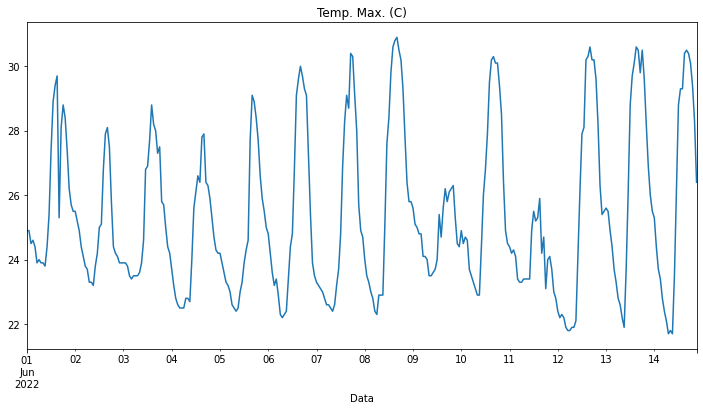

In [ ]:
joaopessoa_pb['Temp. Max. (C)'].plot(figsize = (12,6))
plt.title('Temp. Max. (C)');

Podemos observar uma tendência significativa no nosso gráfico. Vamos continuar com os teste, mas esse já é um bom sinal que a nossa série não é estacionária.

##Autocorrelação

Para verificar até que ponto no passado a correlação se estende, podemos obter a chamada **função de autocorrelação (FAC)**. A FAC com defasagem k é definida como:

$$\rho_k = \frac{\gamma_k}{\gamma_0} = \frac{covariância \ com \ defasagem \ k}{variância} = \phi^k$$ 

uma regra prática é calcular a FAC
até entre um quarto e um terço da duração da série temporal

In [ ]:
int(joaopessoa_pb['Temp. Max. (C)'].shape[0]* (1/4))

83

um quarto do nosso dataset é 83, logo vamos testar a autocorrelação até um lag de 83.

In [ ]:
info = dict()

for i in range(1,84):
  info.update({f'Lag {i}': joaopessoa_pb['Temp. Max. (C)'].autocorr(i).round(2)})
  

tabori = pd.DataFrame(pd.Series(info)).rename(columns = {0:'Correlação de Person'})

tabori.head(18)

  

,Correlação de Person
Lag 1,0.94
Lag 2,0.81
Lag 3,0.64
Lag 4,0.45
Lag 5,0.25
Lag 6,0.04
Lag 7,-0.16
Lag 8,-0.32
Lag 9,-0.45
Lag 10,-0.54


Uma plotagem de $ρ^k$ contra $k$, a duração da defasagem, é chamada de correlograma (amostral).

devemos mencionar um tipo especial de série temporal, a saber, uma série temporal
puramente aleatória, ou de ruído branco. Uma série temporal como essa tem média constante, variância constante (isto é, homocedástica) e é não correlacionada serialmente. Ou seja se a nossa tabela tivesse valores igual a 0 ou muito próximo do mesmo. Iriamos precisar fazer ajustes e normalizações e caso esses processos o resultados fosse o mesmo a séries não seria possível de prever. Para uma série temporal como essa, a FAC em várias defasagens gira em torno de zero e o correlograma não mostra qualquer padrão discernível.

Podemos testar a significância estatística de cada coeficiente de autocorrelação calculando seu erro padrão. O estatístico Bartlett demonstrou que, se uma série temporal for puramente aleatória, a autocorrelação amostral, $ρ^k$
, é aproximadamente distribuída (isto é, em grandes amostras) como segue: 
###$$\hat{ρ} \sim N(0,1/n)$$

Ou seja, em grandes amostras a série temporal é aproximadamente normalmente distribuída com média zero e variância igual a 1 sobre o tamanho da amostra. O tamanho da nossa amostra é 334. Portanto, a variância é 1/334 ou cerca de 0.002 e o erro padrão é $\sqrt{0.002} = 0.05$. Desse modo, de acordo com as propriedades da distribuição normal, o intervalo de confiança de 95% para $ρ_k$
é $[0 ± 1,96(0.05)]$ ou
$(–0,098 \ a \  0,098)$. Algumas das correlações estimadas está nesse intervalo. Desse modo, podemos concluir que alguns os
coeficientes de autocorrelação estimados mostrados na tabela são estatisticamente insignificantes. Trata-se de um sinal que o dataframe talvez seja estacionário.

Em vez de avaliar a significância estatística de um coeficiente de autocorrelação individual, também pode-mos descobrir se a soma dos coeficientes de autocorrelação ao quadrado é estatisticamente significativa. Isso pode ser feito com o auxílio da estatística Q desenvolvida por Box e Pierce, que é definida como

####$$Q = n \sum_{k = 1}^{m} \hat{p}^2_k  $$

onde n é o tamanho da amostra (334, no nosso exemplo) e m é o número total de defasagens utilizadas no cálculo da FAC, 83, no nosso exemplo. A estatística Q é muito utilizada para testar se uma série temporal é puramente aleatória ou de ruído branco. 

Em grandes amostras, Q é aproximadamente distribuído como a distribuição qui-quadrado com m gl. Se, em uma aplicação, o valor calculado de Q for maior que o valor crítico de Q a partir da distribuição qui-qua-drado no nível escolhido de significância, podemos rejeitar a hipótese nula de que todos os ρk
iguais a zero; pelo menos alguns deles devem ser diferentes de zero. 

In [ ]:
tabori['Estatística de Q'] = q_stat(tabori['Correlação de Person'],334 )[0].round(2)
tabori['Prob de Q'] = q_stat(tabori['Correlação de Person'],334 )[1].round(2)


In [ ]:
tabori.head(24)

,Correlação de Person,Estatística de Q,Prob de Q
Lag 1,0.94,297.78,0.0
Lag 2,0.81,519.56,0.0
Lag 3,0.64,658.43,0.0
Lag 4,0.45,727.30,0.0
Lag 5,0.25,748.62,0.0
Lag 6,0.04,749.16,0.0
Lag 7,-0.16,757.95,0.0
Lag 8,-0.32,793.20,0.0
Lag 9,-0.45,863.12,0.0
Lag 10,-0.54,964.13,0.0


A probabilidade de obter esse valor de Q é praticamente nula. Ou seja, a nossa série temporal é não estacionária. Para resumir, há fortes evidências de que a nossa série temporal seja não estacionária.


##O TESTE DE RAIZ UNITÁRIA DA ESTACIONARIEDADE

Podemos usar um teste desenvolvido pelos estatísticos Dickey e Fuller, chamado de **teste τ (tau)**, cujos valores críticos são calculados por meio de simulações – programas estatísticos modernos, São capazes de fazer esses cálculos com facilidade. Na literatura, o teste tau é conhecido como o **teste de Dickey-Fuller (DF)**.

In [ ]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [ ]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(joaopessoa_pb['Temp. Max. (C)'], printResults = True)
print("Essa séries temporal é estacionária? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.008692
P-Value                   0.001366
# Lags Used              16.000000
# Observations Used     317.000000
Critical Value (1%)      -3.451148
Critical Value (5%)      -2.870701
Critical Value (10%)     -2.571651
dtype: float64
Essa séries temporal é estacionária? True


##SÉRIES TEMPORAIS DE DIFERENÇA ESTACIONÁRIA

Há duas maneiras comuns para remover a tendência dos nossos dados:

* Regressão linear

* Diferenciação

Na regressão linear, onde:

$$ \hat{Y} = \beta_0 + \beta_1t $$

$t$ =  variável de tendência assumindo valores cronológicos, 1, 2, ..., n.

Feita a estimátiva da tendência atráves da regressão linear podemos removê-la, da seguinte forma:

$$y_ {detrend} = y_t - \hat{y} = y_t - β_0 + \beta_1t $$



Agora passamos a obter uma série sem tendêcia. O procedimento que acabamos de descrever será válido se a série original apresentar uma **tendência determinística**. 


A diferenciação consiste em tomar diferenças sucessivas da série original até se obter uma série estacionária. A primeira diferença de $Z_t$ é definida por.

A primeira diferença de $Z(t)$ é definida por


$$ Δ Z(t) = Z(t) - Z(t-1)$$

A segunda diferença é

$$ Δ^2Z(t) = Δ\left [ ΔZ(t) \right ] = Δ[Z(t) - Z(t-1)] $$

ou seja,

$$Δ^2Z(t) = Z(t) - 2Z(t-1)+ Z(t-2)$$

De modo geral, a n-ésima diferença de Z(t) é

$$Δ^nZ(t) = Δ[Δ^{n-1}Z(t)]$$


Se uma série temporal se tornar estacionária quando removermos sua tendência com a regressão linear,
isso é chamado de um **processo (estocástico) de tendência estacionária (PTE)**. Se uma série temporal se tornar estacionária depois de tomarmos suas primeiras diferenças, chamare-mos essa série temporal de **processo (estocástico) de diferença estacionária (PDE)**.

###Séries temporais integradas

Em textos sobre as séries temporais, é comum ver o termo **“série temporal integrada”**. Se uma série
temporal como essa se tornar estacionária depois de ser diferenciada uma vez, dir-se-á que ela é integrada de ordem um, indicada como I(1). Se ela tiver de ser diferenciada duas vezes (ou seja, a diferença da diferença) para se tornar estacionária, dir-se-á que ela é integrada de ordem dois, indicada como I(2). Se precisar ser diferenciada d vezes para se tornar estacionária, dir-se-á que ela é integrada de ordem d, denotada como I(d). Uma série temporal estacionária é I(0), ou seja, integrada de ordem zero. Desse modo, os termos “série temporal estacionária” e “série temporal integrada de ordem zero” significam a mesma coisa. Seguindo essa mesma lógica, se uma série temporal for integrada, ela é não estacionária.



##O MODELO DE PASSEIO ALEATÓRIO (MPA)

É comum ouvir que os preços de ativos financeiros, como os preços das ações e taxas de câmbio, seguem um passeio aleatório, ou seja, são não estacionários. Podemos distinguir dois tipos de passeio aleatório: passeio aleatório sem deslocamento (ou seja, sem um termo constante ou intercepto) e passeio aleatório com deslocamento (ou seja, com um termo constante).

####Passeio aleatório sem deslocamento

Vejamos o modelo a seguir:

$$ Y_t = Y_{t-1} + \epsilon_t$$


Para exemplificar vamos usar o preço da gasolina como a nossa variável. Onde:


$Y_t =$ Preço da gasolina hoje. 

$Y_{t-1} =$ Preço da gasolina ontem.

$\epsilon_t =$ Termo de erro, que nesse caso é um ruído branco com média 0 variância $\sigma^2 $ 

pois:

$$\epsilon_t = y_t - \hat{y}_t $$

$y_t = $ Valor observado

$\hat{y}_t = $ Valor previsto

logo:

$$y_1 = y_0 + \epsilon_1$$

$$ y_2 = y_1 + \epsilon_2$$

Substituindo.

$$y_2 = (y_0 + \epsilon_1) + \epsilon_2$$

$$y_3 = (y_0 + \epsilon_1 + \epsilon_2) + \epsilon_3$$


$$\vdots$$

$$y_t = y_0 + \epsilon_1 + \epsilon_2 + \epsilon_3 + ... + \epsilon_t$$


Ou seja:

$$y_t = y_0 + \sum \epsilon_t$$

E como dito antes, para se tratar de um ruído branco é preciso ter as seguinte propriedades:

$E(\epsilon_t) = 0$

$E(\epsilon_t)^2 = \sigma ^2$

$E(\epsilon_t \epsilon_{\tau}) = 0, \ \forall t \neq \tau $


Uma série $y_t:t = 1,2,...,n$ qualquer, e não apenas os resíduos, será considerada ruído branco se $y_1,y_2,...,y_n$ forem independentes e identicamente destribuídos ($i.i.d$) com média igual a 0 e variância positiva e constante. Considerando uma convariância igual a 0, temos um ruíduo branco Gaussiano ou normalmente distribuídos.

Logo a média:

$$E(y_t) = E(y_0) + E \left ( \sum \epsilon_t \right )$$

$$ E(y_t) = y_0$$

A variância da série:

$$Var(y_t) = E(y_t - E(y_t))^2$$

Onde:

$$y_t = y_0 + \epsilon_1 + \epsilon_2 + \epsilon_3 + ... + \epsilon_t$$

$$E(y_t)= y_0$$

Logo

$$Var(y_t) = \not{y_0} + \epsilon_1 + \epsilon_2 + \epsilon_3 + ... + \epsilon_t - \not{y_0}$$

$$Var(y_t) = E(\epsilon_1^2 + \epsilon_2^2 + \epsilon_3^2)$$

$$Var(y_t) = \sigma^2_1 + \sigma^2_2 + ... \sigma^2_t$$

Como nosso dados são bem comportados e a variância é constante, logo:

$$Var(y_t) = t \cdot \sigma^2$$



###Passeio aleatório com deslocamento

Além dos termos visto anteriormente, no passeio aleatório com drift é adicionada uma constante denominada de $δ$:

$$y_t = y_{t-1} + \epsilon_t + δ$$

Onde:

$$y_1 = y_0 + \epsilon_1 + \delta$$
$$y_2 = y_1 + \epsilon_2 + \delta$$

Logo:

$$y_2 = (y_0 + \epsilon_1 + \delta)+  \epsilon_2 + \delta $$

$$y_t = y_0 + t \cdot \delta + \sum_{i =1}^t \epsilon_t $$

onde $δ$ (delta) é conhecido como o parâmetro de deslocamento, que é basicamente um intercepto no MPA.

Logo a média fica assim:

$$E(y_t) = y_0+ t \cdot \delta  $$

Vamos análisar a variância:

$$Var(y_t)= E(y_t - E(y_t) )^2$$

$$Var(y_t) = E(\not{y_0} + \not{t \cdot \delta̸} + \epsilon_1 + \epsilon_2 + ... + \epsilon_t - \not y_0 - \not t \cdot \not \delta)$$

$$Var(y_t)  = E(\epsilon_1 + \epsilon_2 + ... + \epsilon_t)^2 $$

$$Var(y_t) = \sigma^2_1 + \sigma^2_2 + ... + \sigma^2_t$$

$$Var(y_t) = \sigma^2 + \sigma^2 + ... + \sigma^2$$

$$Var(y_t) = t \cdot \sigma^2 $$

Como podemos ver, para o passeio aleatório  com deslocamento, tanto a média quanto a variância aumentam com o tempo. Demostrando assim não ser estácionário.







Criando uma série com distribuição Gaussiana

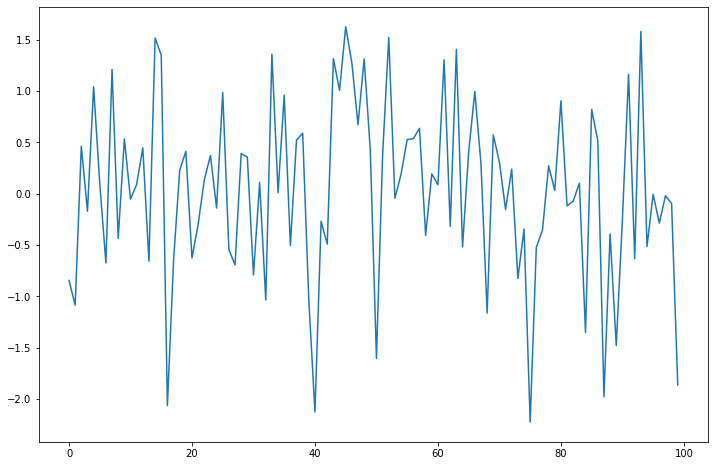

In [ ]:
y = np.random.normal(0,1,100)
plt.figure(figsize = (12,8))
plt.plot(y);

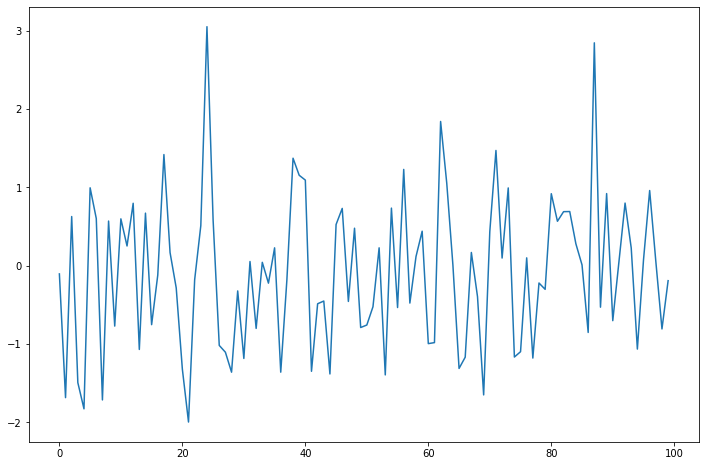

In [ ]:
z = np.random.normal(0,1,100)
plt.figure(figsize = (12,8))
plt.plot(z);

##Modelo Autoregressivo (AR)

O AR toma como premissa que o passado prediz o futuro. Dessa forma ele pressupõe que um processo de série temporal no qual o valor em um ponto no tempo t é uma função dos valores da série em um ponto anterior no tempo. 

A autoregressão é uma regressão em valores passados para predizer valores futuros. O modelo AR(1) se expressa da seguinte forma:

$$y_t = \beta_0 + \beta_1 \cdot y_{t-1} + \epsilon_t$$

Esse é o modelo AR(1) que considera o passado apenas no momento imediato anteior, pois apenas está com um lag de 1.


A generalização da notação anterior onde p é um valor qualquer inferior ao t, podemos rescever a nossa expressão da seguinte forma.
Vamos usar a notação mais trandicional, que usa $\phi_1$ para representar os coeficientes de autoregressão:

AR(p):

$$ y_t = \phi_0 + \phi_1 \cdot y_{t-1} + \phi_2 \cdot y_{t-2} + ... + \phi_p \cdot y_{t-p} + \epsilon_t $$

Assumiso que o processo é estacionário, assim sabemos que o valor esperado em todos os tempo deve ser o mesmo.

$$E(y_t) = \mu = E(y_{t-1})$$

Que pode ser rescrita dessa forma:

$$E(y_t) = E(\phi_0 + \phi_1 \cdot y_{t-1} + \epsilon_t)$$

A esperança de uma constante é a mesma constante, e a gente sabe que a esperança do erro é 0, logo:


$$E(y_t) = \phi_0 + \phi_1 + \mu $$

Simplificando:

$$\mu = \phi_0 + \phi_1 \cdot \mu$$


Que gera a equação:

$$\mu - \phi_1*\mu = \phi_0$$

$$\mu(1-\phi_1) = \phi_0$$

$$\mu = \frac{\phi_0}{1 - \phi_1}$$

Assim encontramos a relação entre a média do processo e os coeficientes AR(1).

Podemos seguir nessa mesma linha para ver como a variância e covariância  constante impõem  condições aos coeficientes $\phi$.

Se:

$$\phi_0 = \mu \cdot (1-\phi_1)$$

Então:

$$y_t = \phi_0 + \phi_1 \cdot y_{t-1} + \epsilon_t$$

$$y_t = (\mu -\mu \cdot \phi_1) + \phi_1 \cdot y_{t-1} + \epsilon_t$$

$$y_t - \mu = \phi_1 (y_{t-1} - \mu) + \epsilon_t$$

Como a séries é estacionária, o calcúlo par t serve para t-1:

$$y_{t-1} - \mu = \phi_1 (y_{t-2} - \mu) + \epsilon_{t-1}$$

Podemos substituir o $y_{t-1}$ na primeira equação de $y_t -\mu$

$$y_t - \mu = \phi_1(\phi_1(y_{t-2} - \mu) + \epsilon_{t-1}) + \epsilon_t$$

O mesmo pode ser feito por $y_{t-2}$.

$$y_t - \mu = \phi_1(\phi_1(\phi_1(y_{t-3 }- \mu)+  \epsilon_{t-2})+ \epsilon_{t-1}) + \epsilon_t$$

Simplificando:

$$y_t -\mu = \epsilon_t + \phi_1 \cdot \epsilon_{t-1} + \phi_1^2 \cdot \epsilon_{t-2} + \phi_1^3 \cdot \epsilon_{t-3}+...+ \phi_1^p \cdot \epsilon_{t-p}$$

Assim para $\infty $ casos, temos:

$$y_t - \mu = \sum^{\infty}_{i= 1} \phi_1^i \cdot \epsilon_{t-i}$$


In [ ]:
df = pd.DataFrame(joaopessoa_pb['Temp. Max. (C)'])

In [ ]:
plt.rcParams["figure.figsize"] = (12,6.5
                                  )

###Função de autocorrelação

A autocorrelação dá uma visão de como os pontos em diferentes períodos no tempo estão linearmente relacionados entre si em função de sua difernça de tempo.

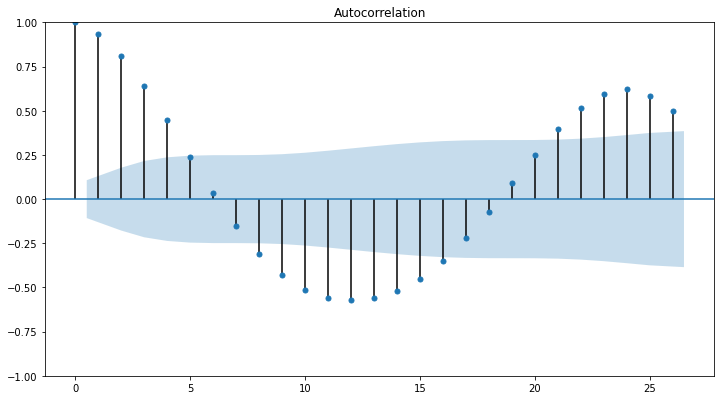

In [ ]:
plot_acf(df)
plt.show();

### Função de autocorrelação parcial

A autocorrelação parcial de uma série temporal para um determinando lag é a correlação parcial dessa série temporal com ela mesma nesse lag, dadas todas as informações entre os dois pontos no tempo.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


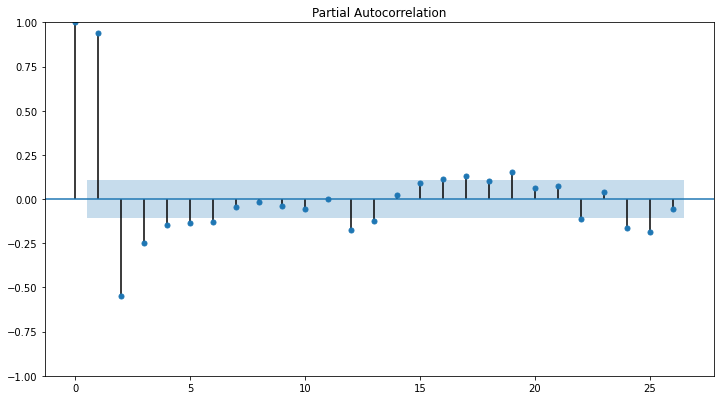

In [ ]:
plot_pacf(df)
plt.show();

Com esses dois gráficos podemos perceber que o nosso modelo tem um AR significativo com alguns picos e MA com uma significância um pouco mais tênue. Vamos agora criar o nosso modelo ARIMA.

##ARIMA
Definido pelas ordens: AR (q), I (d) e MA (q) + Erro advindo do ruído da série.

Um ARIMA definido por (1, 0, 1) é dado por:

$$y_t = \mu + \phi y_{t-1} + \theta y_{y-1} + \epsilon_t$$

Separando treino do teste

In [ ]:
treino = df[:int(len(df)*(3/4))]
teste = df[int(len(df)*(3/4)):]

In [ ]:
#Faazendo um arima na "mão"
from statsmodels.tsa.arima.model import ARIMA


arima = ARIMA(treino, order=(3,0,2))
arima_fit = arima.fit()
print(arima_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Temp. Max. (C)   No. Observations:                  250
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -257.306
Date:                Wed, 15 Jun 2022   AIC                            528.611
Time:                        21:00:42   BIC                            553.261
Sample:                    06-01-2022   HQIC                           538.532
                         - 06-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2805      0.189    133.438      0.000      24.909      25.652
ar.L1          0.9406      0.065     14.508      0.000       0.814       1.068
ar.L2          0.7724      0.084      9.216      0.0

In [ ]:
predito_ARIMA = arima_fit.predict(start = teste.index.min(),end = teste.index.max())

In [ ]:
import matplotlib.pyplot as plt

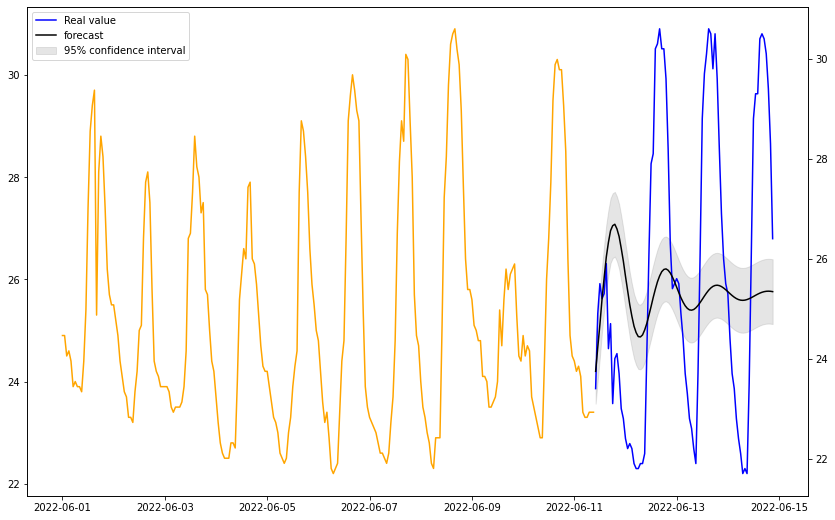

In [ ]:
ci = 1.96 * np.std(teste)/np.sqrt(len(teste))


fig, ax = plt.subplots(figsize = (14,9))
ax.plot(treino.index, treino, color='orange')
ax2 = ax.twinx()
ax2.plot(teste.index, teste, color='blue', label = 'Real value')
ax2.plot(teste.index, predito_AR1, color='black',label='forecast')
ax2.fill_between(teste.index, (predito_ARIMA .values -ci.values), (predito_ARIMA .values+ci.values), color='gray', alpha=.2,label = "95% confidence interval")

plt.legend()
plt.show()



In [ ]:
from pmdarima.arima import AutoARIMA
modelo_autoarima = AutoARIMA( start_p= 1, start_q = 1,start_d = 0,trace = True, max_d = 2,error_action = 'ignore',stepwise = False)

In [ ]:
modelo_autoarima.fit(treino)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1120.789, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=856.512, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=733.521, Time=0.31 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=647.921, Time=0.48 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=618.822, Time=0.23 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=592.720, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=628.240, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=587.468, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=577.333, Time=0.41 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=568.525, Time=0.45 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=568.672, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=564.792, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=531.464, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=536.895, Time=1.27 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=535.319, Time=1.65 sec
 ARIMA(3,0,0)(0,0,0)[1] 

AutoARIMA(error_action='ignore', start_p=1, start_q=1, stepwise=False,
          trace=True)


A gente já tinha descoberto a melhor combinação.



###Métricas para avaliar o modelo

Para analisar se as previsões estão com os valores próximos dos dados reais deve-se fazer a medição do erro, o erro (ou resíduo) neste caso é basicamente $y_{real} - y_{previsão}$

Avalia-se o erro nos dados de treino para verificar se o modelo tem boa assertividade, e valida-se o modelo verificando o erro nos dados de teste (dados que não foram "vistos" pelo modelo).

Abaixo estão as principais métricas usadas para avaliar modelos de séries temporais:

####MEAN FORECAST ERROR - (ERRO MÉDIO DA PREVISÃO ou VIÉS)

O erro médio da previsão nada mais é do que a média dos erros da série avaliada, os valores podem ser positivos ou negativos. Essa métrica sugere que o modelo tende a fazer previsões acima do real (erros negativos) ou abaixo do real (erros positivos), desse modo também pode-se dizer que o erro médio é o viés do modelo.

#### MAE - MEAN ABSOLUTE ERROR - (ERRO MÉDIO ABSOLUTO)

Essa métrica é muito semelhante ao erro médio da previsão mencionado acima, a única diferença é o erro com valor negativo, ou seja, a previsão com valor maior que o número real, é transformado em positivo e posteriormente a média é calculada.

Essa métrica é muito usada em séries temporais, pois há casos que o erro negativo pode zerar o positivo ou dar uma ideia que o modelo é preciso, no caso do MAE isso não acontece, pois essa métrica mostra o quanto a previsão está longe dos valores reais, independente se acima ou abaixo

####MSE - MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO)

Essa métrica coloca mais peso nos erros maiores, pois cada valor individual do erro é elevado ao quadrado e posteriormente a média desses valores é calculada. Assim, essa métrica é muito sensível à outliers e coloca bastante peso nas previsões com erros mais significativos.

Diferente do MAE e MFE, os valores do MSE estão em unidades quadráticas e não na unidade do modelo.

####RMSE - ROOT MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO DA RAIZ)

Essa métrica é simplesmente a raiz quadrada do MSE, onde o erro volta a ter a unidade de medida do modelo (R$/m3), ela é muito usada em séries temporais porque é mais sensível à erros maiores devido ao processo de elevação ao quadrado que a originou.

####MAPE - MEAN ABSOLUTE PERCENTAGE ERROR - (ERRO PERCENTUAL MÉDIO ABSOLUTO)

Essa é outra métrica interessante de ser usada, geralmente usada em relatórios gerenciais, pois o erro é medido em termos percentuais e pode-se comparar o erro percentual do modelo de um produto X com o erro percentual de um produto Y.

O cálculo dessa métrica pega o valor absoluto do erro dividido pelo preço real e posteriormente é calculada a média:

$$MAPE = \frac{100%}{n} \sum _{i = 1}^n \begin{vmatrix}
\frac{y_{real} - y_{previsto}}{y_{real}}\end{vmatrix}$$ 

Vamos criar uma função para avaliar o erro dos dados de treino e teste com várias métricas de avaliação:


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

Vamos analisar toda a série

In [ ]:
check_erro(teste['Temp. Max. (C)'].values,predito_ARIMA,'Temperatura Max. (C)', 'Toda a série' )

,Temperatura Max. (C)
Toda a série,
VIÉS,0.364969
MSE,8.876383
RMSE,2.979326
MAE,2.545027
MAPE,9.747492


Apenas 4 passos na frente

In [ ]:
check_erro(teste['Temp. Max. (C)'].values[:4],predito_ARIMA[:4],'Temperatura Max. (C)', '4 passos na frente' )

,Temperatura Max. (C)
4 passos na frente,
VIÉS,0.290141
MSE,0.312063
RMSE,0.558626
MAE,0.462975
MAPE,1.862101
